<a href="https://colab.research.google.com/github/narayansharma275/pytorch/blob/main/CIFAR_10Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install jovian --upgrade -q
import jovian
jovian.set_project('03-cifar10-feedforward')
jovian.set_colab_id('1wfbot4_spbfGz2KRao1RrnX39n4jdBeg')

In this project, I will

1. Explore the CIFAR10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html

2. Set up a training pipeline to train a neural network on a GPU

3. Experiment with different network architectures & hyperparameters



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
from   torch.utils.data.dataloader import DataLoader
from   torch.utils.data import random_split

from   torchvision.datasets import CIFAR10
from   torchvision.transforms import ToTensor
from   torchvision.utils import make_grid
%matplotlib inline


In [5]:
project_name = "CIFAR10_FNN_Pytorch"

In [6]:
dataset = CIFAR10(root = 'data/', download=True, transform = ToTensor())
test_dataset= CIFAR10(root = 'data/', train = False, transform = ToTensor())

Files already downloaded and verified


In [7]:
#Size of the training and testing dataset

dataset_size = len(dataset)
test_dataset_size = len(test_dataset)
print("training size is",dataset_size)
print("testing size is",test_dataset_size)





training size is 50000
testing size is 10000


In [8]:
#Output classes
classes = dataset.classes
num_classes = len(classes)
print("The classes are {}\nand total number of classes are {}".format(classes, num_classes))

The classes are ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
and total number of classes are 10


In [9]:
#Shape of an image tensor

img,label = dataset[1]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

The dataset contains 3 Channel color images of size 32x32. 

Label (Num) -  9
Lalbe (TEXT) - truck


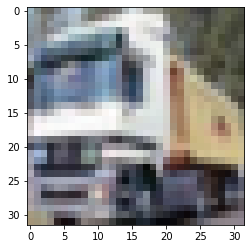

In [10]:
plt.imshow(img.permute(1,2,0))
print('Label (Num) - ', label)
print('Lalbe (TEXT) -', classes[label])

In [11]:
#No of images of each class
class_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
def class_counter(class_dict, class_no):
  class_dict[class_no]+= 1
  return class_dict

for _,class_no in dataset:
  class_dict = class_counter(class_dict, class_no)

for k,v in class_dict.items():
  print("Number of images of [class {}] are {}". format(classes[k],v)) 

Number of images of [class airplane] are 5000
Number of images of [class automobile] are 5000
Number of images of [class bird] are 5000
Number of images of [class cat] are 5000
Number of images of [class deer] are 5000
Number of images of [class dog] are 5000
Number of images of [class frog] are 5000
Number of images of [class horse] are 5000
Number of images of [class ship] are 5000
Number of images of [class truck] are 5000


In [12]:
!pip install jovian --upgrade --quiet

In [13]:
import jovian
jovian.commit(project= project_name, environment= None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/narayansharma275/cifar10-fnn-pytorch


'https://jovian.ai/narayansharma275/cifar10-fnn-pytorch'

Preparing the Data For Training

In [14]:
#Validation set of 5000 images (10% of training data)

torch.manual_seed(43)
val_size = int(len(dataset)* 0.1)
train_size = len(dataset)- val_size

print(train_size, val_size)

45000 5000


In [15]:
#Splitting into test and train data

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [16]:
#Creating DataLoaders

batch_size = 256

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([256, 3, 32, 32])


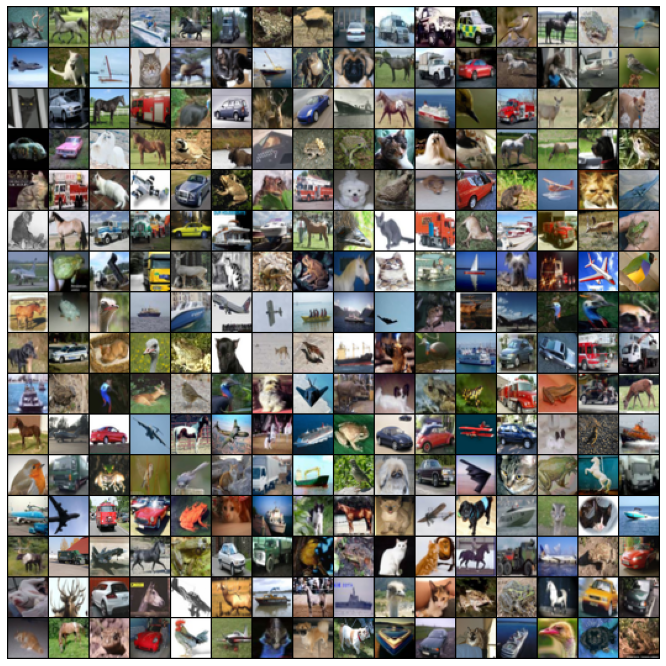

In [17]:
#Visualizing a batch of data

for images,_ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(20,12))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow= 16,padding =1).permute(1,2,0))
  break


## Base Model Class and Training on GPU

In [18]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [19]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    outputs = self(images)    
    loss = F.cross_entropy(outputs,labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    outputs = self(images)
    loss = F.cross_entropy(outputs, labels)
    acc = accuracy(outputs, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}  

  def validation_epoch_end(self, outputs):
    batch_losses =  [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.3f}, val_acc: {:.3f}".format(epoch,result['val_loss'], result['val_acc']))


In [20]:
def evaluate (model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func= torch.optim.SGD):
  history = []

  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    #TRAINING PHASE
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #Validation Phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [21]:
#Other Utilities

torch.cuda.is_available()

True

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Helper Functions for Losses and Accuracies

In [25]:
def plot_losses(history):
  losses = [result['val_loss'] for result in history]
  plt.plot(losses, '-o')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs No. of Epochs')

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [27]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)


In [28]:
input_size = 3*32*32
output_size = 10

In [29]:
class CIFAR10Model(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.linear1= nn.Linear(input_size, 256)
    self.linear2= nn.Linear(256,128)
    self.linear3= nn.Linear(128,64)
    self.linear4= nn.Linear(64,32)
    self.linear5= nn.Linear(32,output_size)

  def forward(self, xb):
    #Flattening 
    out = xb.view(xb.size(0),-1)
    # Applying layers & activation functions
    out = self.linear1(out)
    out=  F.relu(out)
    out=  self.linear2(out)
    out=  F.relu(out)
    out=  self.linear3(out)
    out=  F.relu(out)
    out=  self.linear4(out)
    out=  F.relu(out)
    out=  self.linear5(out)

    return out


In [30]:
model = to_device(CIFAR10Model(), device)

In [31]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.0998365730047226, 'val_loss': 2.3071792125701904}]

In [32]:
history += fit(5,0.1, model, train_loader, val_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.161, val_acc: 0.180
Epoch [1], val_loss: 2.058, val_acc: 0.239
Epoch [2], val_loss: 1.946, val_acc: 0.286
Epoch [3], val_loss: 1.892, val_acc: 0.320
Epoch [4], val_loss: 1.939, val_acc: 0.276


In [33]:
history += fit(20, 0.05, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.808, val_acc: 0.348
Epoch [1], val_loss: 1.806, val_acc: 0.351
Epoch [2], val_loss: 1.736, val_acc: 0.377
Epoch [3], val_loss: 1.731, val_acc: 0.374
Epoch [4], val_loss: 1.670, val_acc: 0.397
Epoch [5], val_loss: 1.666, val_acc: 0.403
Epoch [6], val_loss: 1.629, val_acc: 0.409
Epoch [7], val_loss: 1.592, val_acc: 0.437
Epoch [8], val_loss: 1.582, val_acc: 0.434
Epoch [9], val_loss: 1.635, val_acc: 0.410
Epoch [10], val_loss: 1.574, val_acc: 0.433
Epoch [11], val_loss: 1.621, val_acc: 0.411
Epoch [12], val_loss: 1.540, val_acc: 0.441
Epoch [13], val_loss: 1.567, val_acc: 0.442
Epoch [14], val_loss: 1.525, val_acc: 0.450
Epoch [15], val_loss: 1.604, val_acc: 0.438
Epoch [16], val_loss: 1.536, val_acc: 0.449
Epoch [17], val_loss: 1.537, val_acc: 0.458
Epoch [18], val_loss: 1.488, val_acc: 0.470
Epoch [19], val_loss: 1.510, val_acc: 0.456


In [34]:
history += fit(10, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.431, val_acc: 0.487
Epoch [1], val_loss: 1.426, val_acc: 0.491
Epoch [2], val_loss: 1.426, val_acc: 0.487
Epoch [3], val_loss: 1.428, val_acc: 0.489
Epoch [4], val_loss: 1.413, val_acc: 0.493
Epoch [5], val_loss: 1.415, val_acc: 0.491
Epoch [6], val_loss: 1.415, val_acc: 0.493
Epoch [7], val_loss: 1.407, val_acc: 0.498
Epoch [8], val_loss: 1.405, val_acc: 0.498
Epoch [9], val_loss: 1.408, val_acc: 0.494


In [35]:
history += fit(10, 0.0075, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.402, val_acc: 0.503
Epoch [1], val_loss: 1.405, val_acc: 0.498
Epoch [2], val_loss: 1.396, val_acc: 0.503
Epoch [3], val_loss: 1.399, val_acc: 0.504
Epoch [4], val_loss: 1.398, val_acc: 0.504
Epoch [5], val_loss: 1.393, val_acc: 0.504
Epoch [6], val_loss: 1.395, val_acc: 0.502
Epoch [7], val_loss: 1.390, val_acc: 0.507
Epoch [8], val_loss: 1.399, val_acc: 0.508
Epoch [9], val_loss: 1.389, val_acc: 0.503


In [36]:
history += fit(10, 0.005, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.388, val_acc: 0.507
Epoch [1], val_loss: 1.387, val_acc: 0.508
Epoch [2], val_loss: 1.383, val_acc: 0.508
Epoch [3], val_loss: 1.384, val_acc: 0.510
Epoch [4], val_loss: 1.383, val_acc: 0.511
Epoch [5], val_loss: 1.383, val_acc: 0.509
Epoch [6], val_loss: 1.378, val_acc: 0.513
Epoch [7], val_loss: 1.377, val_acc: 0.513
Epoch [8], val_loss: 1.373, val_acc: 0.512
Epoch [9], val_loss: 1.384, val_acc: 0.513


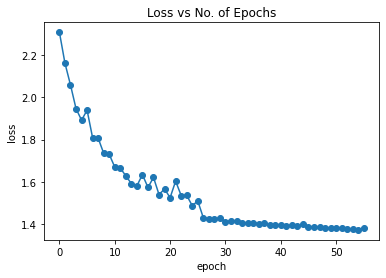

In [37]:
plot_losses(history)

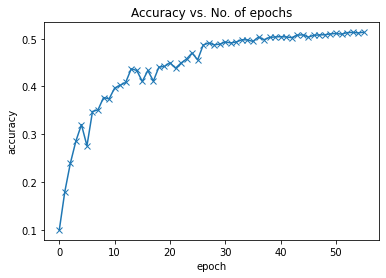

In [38]:
plot_accuracies(history)

In [39]:
#Evaluating Test Results
evaluate(model,test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.529101550579071, 'val_loss': 1.3350633382797241}

In [41]:
#Saving the model summaries
architecture = "5 Layers (256, 128, 64, 32,10)"
lrs= [0.1,0.05,0.01,0.0075,0.005]
epochs = [5,20,10,10,10]
test_accuracy =  0.529101550579071
test_loss = 1.3350633382797241

In [42]:
torch.save(model.state_dict(), 'cifar10_ffn_pytorch.pth')

In [43]:
jovian.reset()

jovian.log_hyperparams(arch=architecture, lrs=lrs, epochs=epochs)

[jovian] Hyperparams logged.


In [44]:
jovian.log_metrics(test_loss=test_loss, test_acc=test_accuracy)

[jovian] Metrics logged.


In [45]:
jovian.commit(project=project_name, outputs=['cifar10_ffn_pytorch.pth'], environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/narayansharma275/cifar10-fnn-pytorch


'https://jovian.ai/narayansharma275/cifar10-fnn-pytorch'